In [41]:
import warnings

In [42]:
warnings.filterwarnings('ignore')

In [43]:
#Import all necessary libraries
import glob
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import fastparquet
import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

import re
import random
import collections
import seaborn as sns

from gensim import corpora, models
import gensim
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

# 1. Topic Model on CommonCrawl


## 1.1. Loading and Filtering the Data
There are 28 files with ~2500 records each. 

In [40]:
result = pd.read_csv('gutenberg/cleansed_summarized.csv')
result.head()

author  \
0  Ranke, Leopold von   
1  Ranke, Leopold von   
2  Ranke, Leopold von   
3  Ranke, Leopold von   
4  Ranke, Leopold von   

                                                                      title  \
0  Vom Einfluß der Theorie                                                    
1  Über die Verwandtschaft und den Unterschied der Historie und der Politik   
2  Über die Epochen der neueren Geschichte                                    
3  Politisches Gespräch                                                       
4  Geschichte und Philosophie                                                 

        genre  \
0  Geschichte   
1  Geschichte   
2  Geschichte   
3  Geschichte   
4  Geschichte   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## 1.2 Constructing the Corpus and Building the Model

In [4]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text(record):
    text = record['chapter']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = pd.read_csv("gutenberg/stopwords.csv")["word"].to_list()

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-ZäöüÄÖÜß0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%%time
#build gensim corpus

# result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text(row))

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 29 s


In [6]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/15, random_state=1)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 48.8 s


## 1.3 Inspecting the Results

In [7]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 15.6 s


In [10]:
dfnormal.head(20)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,12,0,1,2,3,4,5,6,7,8,9,10,11,13,14
0,0.997150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.998592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.998230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.013355,0.013355,0.372587,0.013355,0.013355,0.013355,0.013355,0.013355,0.013355,0.013355,0.013355,0.013355,0.013355,0.453802,0.013355
4,0.993891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.484631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514293,NaN,NaN,NaN,NaN,NaN,NaN
6,0.395988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076890,NaN,NaN,NaN,NaN,0.470188,0.054486
7,0.074327,NaN,0.016898,NaN,NaN,NaN,NaN,NaN,0.658987,0.132584,NaN,NaN,0.073687,0.042796,NaN
8,0.998776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999645,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.005*"rom" + 0.004*"stadt" + 0.003*"kunst" + 0.002*"geschichte" + 0.002*"deutschen" + 0.002*"dichter" + 0.002*"natur" + 0.002*"paris"'),
 (1,
  '0.006*"frau" + 0.004*"vater" + 0.003*"mutter" + 0.003*"herr" + 0.003*"hand" + 0.002*"hause" + 0.002*"weiß" + 0.002*"liebe"'),
 (2,
  '0.004*"bonaparte" + 0.003*"nationalversammlung" + 0.003*"bourgeoisie" + 0.002*"wien" + 0.002*"bauern" + 0.002*"gesellschaft" + 0.002*"stadt" + 0.002*"ton"'),
 (3,
  '0.003*"rhythmus" + 0.003*"theater" + 0.002*"liebe" + 0.002*"rhythmischen" + 0.002*"herrn" + 0.001*"geschichte" + 0.001*"glas" + 0.001*"licht"'),
 (4,
  '0.003*"frau" + 0.002*"erde" + 0.002*"arbeit" + 0.002*"don" + 0.002*"liebe" + 0.002*"dinge" + 0.002*"kunst" + 0.002*"natur"'),
 (5,
  '0.003*"geschichte" + 0.003*"liebe" + 0.003*"deutschen" + 0.003*"deutschland" + 0.002*"männer" + 0.002*"weise" + 0.002*"england" + 0.002*"shakespeare"'),
 (6,
  '0.004*"ward" + 0.003*"stadt" + 0.002*"paris" + 0.002*"revolution" + 0.002*"mußte" + 0.002*"leute" 

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


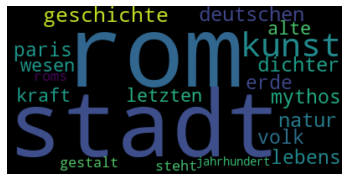

Topic Id = 0


In [12]:
topicId = 0

#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[topicId,i]


# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Topic Id = " + str(topicId))

In [13]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001827  0.034034       1        1   2.252999
1     -0.050454 -0.047445       2        1  14.874474
2     -0.007593  0.024352       3        1   1.121974
3      0.018112 -0.006368       4        1   0.233829
4     -0.003470  0.015814       5        1   2.016063
5     -0.002414  0.025486       6        1   2.242044
6     -0.024293 -0.003245       7        1   2.490944
7     -0.028864  0.015395       8        1  10.028431
8     -0.073349 -0.055850       9        1  11.845663
9     -0.035204  0.019905      10        1   1.198374
10     0.175317 -0.081851      11        1   3.859533
11    -0.021211 -0.093788      12        1  10.306230
12     0.072926  0.108126      13        1  19.850440
13    -0.010305  0.046039      14        1  16.988185
14    -0.007370 -0.000604      15        1   0.690818, topic_info=             Term         Freq        Total Category  logprob  loglift
9253     bedeutet   874.000000   874.000000  Default  30.0000  30.0000
2861        herrn  1331.000000  1331.000000  Default  29.0000  29.0000
317    bezeichnet   723.000000   723.000000  Default  28.0000  28.0000
1794        guten  1264.000000  1264.000000  Default  27.0000  27.0000
482         liebe  1947.000000  1947.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1100  deutschland     8.355055   980.484386  Topic15  -6.7953   0.2099
1302       schien     7.947215   747.795828  Topic15  -6.8453   0.4307
1318       sprach     8.402922  1245.904861  Topic15  -6.7896  -0.0240
501         natur     8.709458  2044.357059  Topic15  -6.7537  -0.4834
643         weder     7.821005   762.982573  Topic15  -6.8613   0.3946

[1117 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14856      3  0.086407        113
14856      6  0.259221        113
14856      9  0.086407        113
14856     11  0.086407        113
14856     13  0.259221        113
...      ...       ...        ...
12026      9  0.116718  übergänge
12026     11  0.058359  übergänge
12026     12  0.116718  übergänge
12026     13  0.291794  übergänge
12026     14  0.058359  übergänge

[8623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [14]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
df = pd.concat([result[['author', 'title', 'genre']], dfnormal], axis=1)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


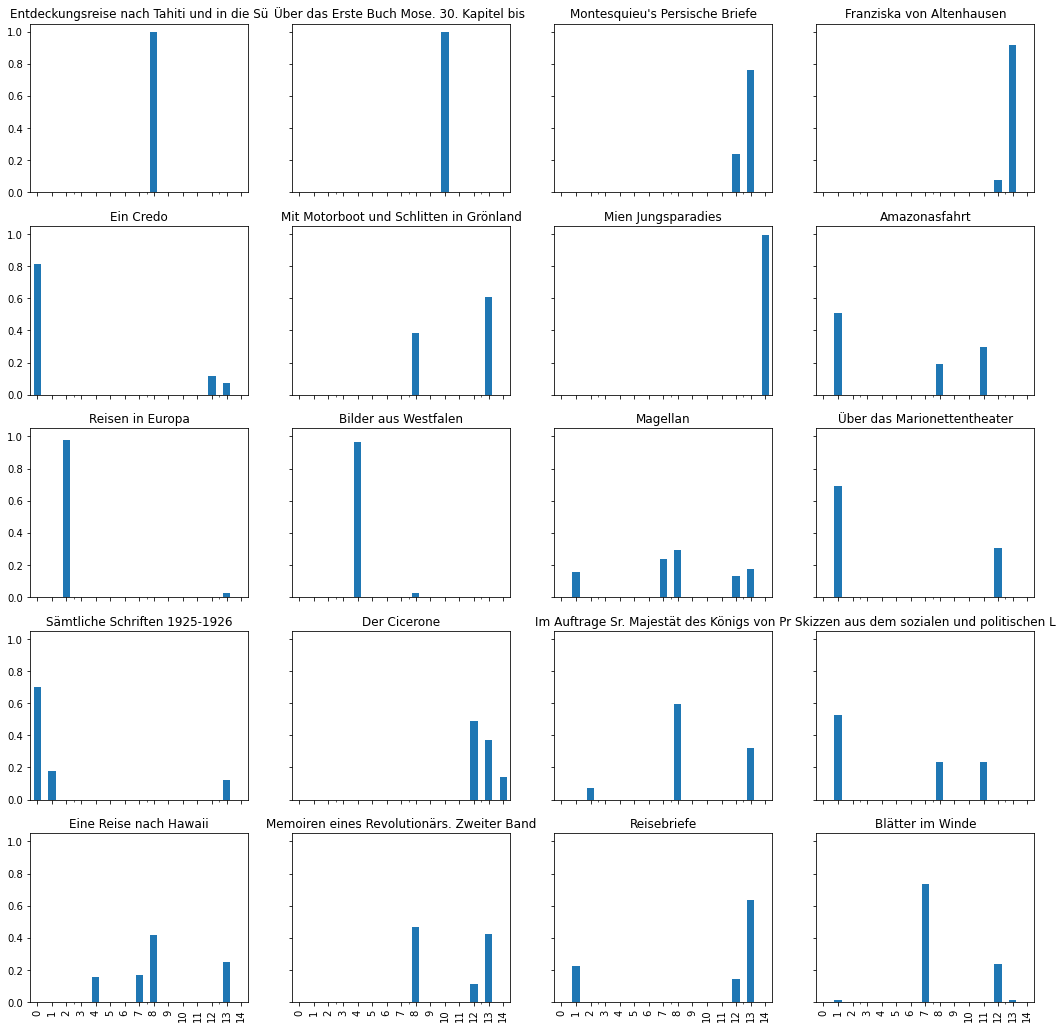

In [37]:
df_plot = df.drop(['author', 'title', 'genre'], axis=1).sample(frac=1, random_state=10).head(20).transpose().sort_index()

fig, axes = plt.subplots(5, 4, sharex=True, sharey=True, figsize=(18,18))

index_list = df_plot.columns
index = 0
for ax in axes.flatten():
    df_plot[index_list[index]].plot.bar(ax=ax)
    ax.set_title(df['title'].iloc[index_list[index]][0:42])
    index += 1

In [16]:
df_topic = df[['author', 'title', 'genre', 11]].sort_values(by=11, ascending=False)
df_topic.head(10)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,title,genre,11
443,"Luther, Martin",Die Bibel,Philosophie und Religion,0.999906
239,Klabund,Mohammed - Roman eines Propheten,Biographie,0.999789
17,"Wilde, Oscar",Salome,Kultur und Kunst,0.999102
980,"Kisch, Egon Erwin",Zaren - Popen - Bolschewiken,Geschichte,0.999051
786,"Hofmannsthal, Hugo von",Der Wanderer (aus: Augenblicke in Griechenland),"Natur, Wissen und Reise",0.998849
788,"Hofmannsthal, Hugo von",Das Kloster des Heiligen Lukas,"Natur, Wissen und Reise",0.998744
299,Prophet Mohammed,Der Koran,Philosophie und Religion,0.997424
340,"Bermann, Richard Arnold",Tausend und eine Insel,"Natur, Wissen und Reise",0.997283
948,"Kastein, Josef",Und Friede auf Erden,Kultur und Kunst,0.996929
570,"Strindberg, August",Inferno,Biographie,0.996696


In [17]:
df_topic = df[['author', 'title', 'genre', 8]].sort_values(by=8, ascending=False)
df_topic.head(20)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,title,genre,8
154,Verschiedene Autoren,Auf Kreuzfahrt durch die Südsee,"Natur, Wissen und Reise",0.999926
148,"Verne, Jules",Die großen Seefahrer des 18. Jahrhunderts - Zweiter Band,Biographie,0.999917
347,"Möllhausen, Balduin",Reisen in die Felsengebirge Nordamerikas - Band 2,"Natur, Wissen und Reise",0.999525
269,"Gerstäcker, Friedrich",Australien,"Natur, Wissen und Reise",0.999484
650,"Southey, Robert",Nelson's Leben,Biographie,0.999357
335,"Gerstäcker, Friedrich",Südamerika,"Natur, Wissen und Reise",0.999263
268,"Gerstäcker, Friedrich",Die Südsee-Inseln,"Natur, Wissen und Reise",0.999193
176,"Nansen, Fritjof",Durch Nacht und Eis. Band 2,"Natur, Wissen und Reise",0.999152
356,"Gerstäcker, Friedrich",Californien,"Natur, Wissen und Reise",0.999085
170,"Nordenskjöld, Otto",Antarctic. Band II,"Natur, Wissen und Reise",0.998949


In [18]:
df_topic = df[['author', 'title', 'genre', 1, 11]]
df_topic = df_topic[(df[1] > 0.4) & (df[11] > 0.4)]
df_topic.head(10)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,title,genre,1,11
144,"Wassermann, Jakob",Caspar Hauser oder Die Trägheit des Herzens,Biographie,0.553195,0.445981
223,"Schneider, Manfred",Don Francsico de Goya,Biographie,0.406688,0.592062
238,Klabund,Moreau,Biographie,0.434137,0.480649
260,"Ewers, Hanns Heinz",Von sieben Meeren,"Natur, Wissen und Reise",0.539780,0.449184
273,"Wolff, Theodor",Spaziergänge,Kultur und Kunst,0.409069,0.578514
313,"Jung-Stilling, Johann Heinrich",Henrich Stillings Jugend,Biographie,0.537491,0.461135
573,"Reventlow, Franziska zu",Skizzen und Aufsätze,Kultur und Kunst,0.563431,0.430820
941,"Kisch, Egon Erwin",Marktplatz der Sensationen,Kultur und Kunst,0.408720,0.488146
945,"Kisch, Egon Erwin",Der rasende Reporter,Kultur und Kunst,0.479059,0.518495
1208,"Heine, Heinrich",Das Buch Le Grand,Kultur und Kunst,0.576810,0.419646


In [19]:
df_topic = df[['author', 'title', 'genre', 1, 8]]
df_topic = df_topic[(df[1] > 0.4) & (df[8] > 0.4)]
df_topic.head(10)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,title,genre,1,8
251,"Helling, Viktor",Exotische See- und Reiseerlebnisse,"Natur, Wissen und Reise",0.496329,0.493592
480,"Wildgans, Anton",Musik der Kindheit,Biographie,0.497042,0.498761
661,"Schuyler, Eugen",Erinnerungen an den Grafen Leo Tolstoi,Biographie,0.447457,0.551054


# Number of toppics changed

In [20]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/6, random_state=1)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 28.8 s


In [21]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 5.83 s


In [24]:
dfnormal.head(20)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,2,5,1,3,4
0,0.103147,0.894801,NaN,NaN,NaN,NaN
1,0.189988,0.783594,0.025656,NaN,NaN,NaN
2,NaN,0.998408,NaN,NaN,NaN,NaN
3,0.033682,0.033649,0.033770,0.831886,0.033481,0.033531
4,NaN,0.994498,NaN,NaN,NaN,NaN
5,0.930156,0.069009,NaN,NaN,NaN,NaN
6,0.839635,0.158121,NaN,NaN,NaN,NaN
7,NaN,0.051840,0.534516,0.269016,NaN,0.140827
8,0.214308,0.784810,NaN,NaN,NaN,NaN
9,0.331810,NaN,0.609635,NaN,NaN,0.058308


In [25]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.003*"deutschen" + 0.002*"deutschland" + 0.002*"kunst" + 0.002*"geschichte" + 0.002*"natur" + 0.002*"deutsche" + 0.002*"volk" + 0.002*"freiheit"'),
 (1,
  '0.003*"frau" + 0.003*"vater" + 0.003*"herr" + 0.003*"mutter" + 0.002*"hand" + 0.002*"weiß" + 0.002*"mußte" + 0.002*"stand"'),
 (2,
  '0.005*"natur" + 0.004*"kunst" + 0.002*"form" + 0.002*"wesen" + 0.002*"bloß" + 0.002*"geist" + 0.002*"lebens" + 0.002*"seele"'),
 (3,
  '0.010*"bedeutet" + 0.008*"bezeichnet" + 0.007*"herrn" + 0.007*"guten" + 0.006*"kirche" + 0.006*"mose" + 0.006*"wahren" + 0.006*"bedeutung"'),
 (4,
  '0.003*"land" + 0.003*"insel" + 0.002*"schiff" + 0.002*"wasser" + 0.002*"stadt" + 0.002*"reise" + 0.002*"ließ" + 0.002*"see"'),
 (5,
  '0.004*"sprach" + 0.003*"ward" + 0.003*"liebe" + 0.003*"herr" + 0.002*"rom" + 0.002*"vater" + 0.002*"geschichte" + 0.002*"stadt"')]

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


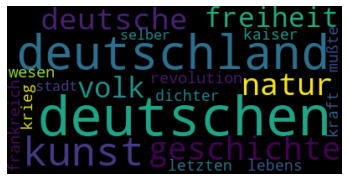

Topic Id = 0


In [26]:
topicId = 0

#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[topicId,i]


# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Topic Id = " + str(topicId))

In [27]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.023892 -0.043952  1       1        18.776386
1      0.044300  0.055406  2       1        28.878495
2     -0.016090 -0.078461  3       1        19.137672
3     -0.112469  0.032876  4       1        5.001762 
4      0.049102  0.017081  5       1        13.716621
5      0.011265  0.017049  6       1        14.489065, topic_info=            Term         Freq        Total Category  logprob  loglift
9253  bedeutet    825.000000   825.000000   Default  30.0000  30.0000
2861  herrn       1273.000000  1273.000000  Default  29.0000  29.0000
1794  guten       1218.000000  1218.000000  Default  28.0000  28.0000
317   bezeichnet  683.000000   683.000000   Default  27.0000  27.0000
5780  kirche      869.000000   869.000000   Default  26.0000  26.0000
...      ...             ...          ...       ...      ...      ...
1387  volk        186.684837   944.981541   Topic6  -6.7320   0.3100 
2842  hand        203.424645   1489.894889  Topic6  -6.6461  -0.0594 
642   wahrheit    190.883465   1068.495647  Topic6  -6.7097   0.2094 
1266  mußte       194.551806   1542.781565  Topic6  -6.6907  -0.1389 
501   natur       187.452186   2108.479280  Topic6  -6.7279  -0.4884 

[494 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13606  1      0.043137  1788     
13606  2      0.094900  1788     
13606  3      0.017255  1788     
13606  4      0.008627  1788     
13606  5      0.060391  1788     
...   ..           ...   ...     
4938   2      0.039324  östlicher
4938   3      0.039324  östlicher
4938   4      0.039324  östlicher
4938   5      0.786474  östlicher
4938   6      0.039324  östlicher

[2388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [28]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/20, random_state=1)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 1min


In [29]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 13 s


In [32]:
dfnormal.head(20)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,12,13,0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,17,18,19
0,0.997099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.931957,0.066685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.998198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.010016,0.423093,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.010016,0.396611,0.010016,0.010016
4,0.892035,0.102072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.392756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.178507,0.711029,NaN,NaN,NaN,NaN,NaN,NaN,0.107625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.915487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083432,NaN,NaN
8,0.833096,0.165724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.936993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062665


In [33]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.006*"rom" + 0.004*"stadt" + 0.003*"kunst" + 0.002*"straßen" + 0.002*"roms" + 0.001*"natur" + 0.001*"deutschen" + 0.001*"letzten"'),
 (1,
  '0.006*"frau" + 0.003*"dichter" + 0.003*"liebe" + 0.002*"ibsen" + 0.002*"mutter" + 0.002*"deutschen" + 0.002*"mußte" + 0.002*"musik"'),
 (2,
  '0.018*"bedeutet" + 0.013*"bezeichnet" + 0.011*"herrn" + 0.011*"guten" + 0.010*"mose" + 0.010*"kirche" + 0.009*"wahren" + 0.009*"bedeutung"'),
 (3,
  '0.004*"töne" + 0.004*"ton" + 0.003*"mais" + 0.003*"wellen" + 0.002*"luft" + 0.002*"ohr" + 0.002*"bewegung" + 0.002*"genau"'),
 (4,
  '0.002*"kunst" + 0.002*"arbeit" + 0.002*"frau" + 0.002*"bewegung" + 0.002*"seele" + 0.002*"natur" + 0.002*"lebens" + 0.002*"wesen"'),
 (5,
  '0.004*"liebe" + 0.003*"geschichte" + 0.003*"personen" + 0.003*"männer" + 0.002*"frau" + 0.002*"frauen" + 0.002*"weise" + 0.002*"deutschen"'),
 (6,
  '0.003*"ward" + 0.003*"revolution" + 0.003*"frankreich" + 0.002*"krieg" + 0.002*"stadt" + 0.002*"deutschen" + 0.002*"paris" + 0.002*"

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


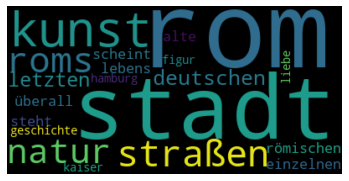

Topic Id = 0


In [34]:
topicId = 0

#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[topicId,i]


# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Topic Id = " + str(topicId))

In [35]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

c:\programdata\anaconda3\envs\twm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.016260  0.024459  1       1        0.916716 
1      0.021787  0.012336  2       1        3.988077 
2     -0.242345 -0.039355  3       1        3.805046 
3     -0.013656  0.001963  4       1        0.355713 
4      0.012001  0.017601  5       1        0.975817 
5      0.004913  0.015580  6       1        1.640921 
6      0.054334  0.006631  7       1        10.360576
7      0.000711 -0.003911  8       1        2.151607 
8      0.071800 -0.082187  9       1        7.578417 
9      0.019866  0.018208  10      1        0.460566 
10    -0.022835 -0.003262  11      1        1.239757 
11    -0.022877 -0.011889  12      1        2.883436 
12    -0.046131  0.131413  13      1        17.035021
13     0.022297  0.071046  14      1        15.095286
14    -0.032938 -0.087359  15      1        1.324446 
15     0.029731 -0.048568  16      1        2.519454 
16     0.025917  0.012216  17      1        0.860319 
17     0.035361 -0.074904  18      1        23.258042
18     0.004002  0.047124  19      1        0.989485 
19     0.061802 -0.007143  20      1        2.561297 , topic_info=            Term         Freq        Total Category  logprob  loglift
1318  sprach      1099.000000  1099.000000  Default  30.0000  30.0000
9253  bedeutet    980.000000   980.000000   Default  29.0000  29.0000
2859  herr        1721.000000  1721.000000  Default  28.0000  28.0000
2861  herrn       1353.000000  1353.000000  Default  27.0000  27.0000
482   liebe       1946.000000  1946.000000  Default  26.0000  26.0000
...     ...               ...          ...      ...      ...      ...
424   geschichte  43.531456    1459.041701  Topic20 -6.4550   0.1526 
1848  ließ        41.501322    1305.070778  Topic20 -6.5028   0.2164 
539   seite       38.415678    1109.289762  Topic20 -6.5801   0.3016 
645   weise       37.997317    1242.553987  Topic20 -6.5910   0.1772 
644   weg         37.291332    1173.419444  Topic20 -6.6098   0.2157 

[1463 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
14856  2      0.176190  113        
14856  3      0.088095  113        
14856  6      0.264285  113        
14856  9      0.088095  113        
14856  13     0.176190  113        
...   ..           ...  ...        
5330   14     0.661470  übersetzung
5330   15     0.009873  übersetzung
5330   16     0.019745  übersetzung
5330   18     0.108600  übersetzung
5330   20     0.019745  übersetzung

[12780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])